In [34]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

The following line is needed to download the example FITS files used here.

In [35]:
from astropy.utils.data import download_file

# Viewing and manipulating FITS images

In [36]:
from astropy.io import fits

In [37]:
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

## Opening FITS files and loading the image data

I will open the FITS file and find out what it contains.

In [38]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: /home/david/.astropy/cache/download/2c9202ae878ecfcb60878ceb63837f5f
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     161   (891, 893)   int16   
1    er.mask     TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [39]:
image_data = hdu_list[0].data

You data is now stored as a 2-D numpy array.  Want to know the dimensions of the image?  Just look at the `shape` of the array.

In [40]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


At this point, we can just close the FITS file.  We have stored everything we wanted to a variable.

In [41]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [42]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


## Viewing the image data and getting basic statistics

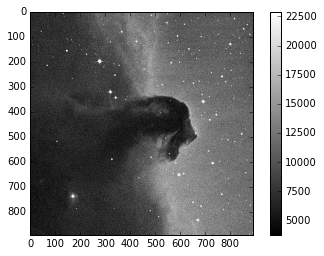

In [43]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()
# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image

In [44]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.48167629
Stdev: 3032.3927542


### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, I need to cast the data from a 2-D to array to something one dimensional.

In this case, I am using the iterable python object `img_data.flat`.

In [45]:
#print(type(image_data.flat))

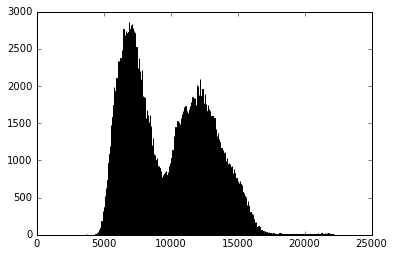

In [46]:
NBINS = 1000
histogram = plt.hist(np.array(image_data.flat), NBINS)

### Displaying the image with a logarithmic scale

Want to use a logarithmic color scale? To do so we need to load the `LogNorm` object from `matplotlib`.

In [47]:
from matplotlib.colors import LogNorm

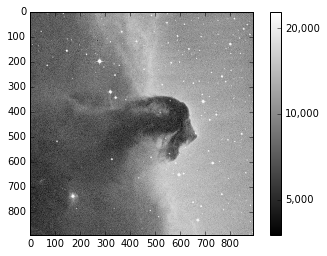

In [48]:
plt.imshow(image_data, cmap='gray', norm=LogNorm())
#plt.imshow(image_data, cmap='viridis', norm=LogNorm())
# I chose the tick marks based on the histogram above
# Overlay a contour from a FITS file with a different WCS
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

## Basic image math: image stacking

You can perform math with the image data like any other numpy array.  In this particular example, I will stack several images of M13 taken with a ~10'' telescope.

I open a series of FITS files and store the data in a list, which I've named `image_concat`.

In [49]:
image_list = [ download_file('http://data.astropy.org/tutorials/FITS-images/M13_blue_000'+n+'.fits', cache=True ) \
              for n in ['1','2','3','4','5'] ]

# The long way
image_concat = []
for image in image_list:
    image_concat.append(fits.getdata(image))
    
# The short way
#image_concat = [ fits.getdata(image) for image in IMAGE_LIST ]

Now I'll stack the images by summing my concatenated list.

In [50]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
#final_image = np.sum(image_concat, axis=0)

I'm going to show the image, but I want to decide on the best stretch. To do so I'll plot a histogram of the data.

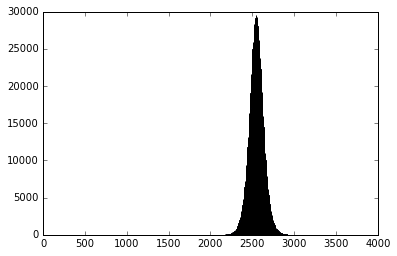

In [51]:
image_hist = plt.hist(np.array(final_image.flat), 1000)

I'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`.

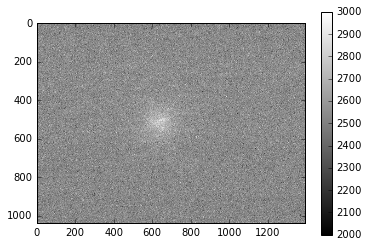

In [52]:
plt.imshow(final_image, cmap='gray', vmin=2.e3, vmax=3.e3)
#plt.imshow(final_image, cmap='plasma', vmin=2.e3, vmax=3.e3)
plt.colorbar()

Statistics on part of the image only:

In [53]:
np.mean(final_image[500:600,600:700])

2687.7682

## Writing image data to a FITS file

This is easy to do with the `writeto()` method.

You will receive an error if the file you are trying to write already exists.  That's why I've set `clobber=True`. First, we create a PrimaryHDU object to encapsulate the data and write to the new file

In [55]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, clobber=True)